# Análisis con los datos disponibles del REPDA

## ¿De dónde provienen los datos?
Los datos provienen del conjunto [Concesiones, asignaciones, permisos otorgados y registros de obras situadas en zonas de libre alumbramiento de CONAGUA](https://datos.gob.mx/busca/dataset/concesiones-asignaciones-permisos-otorgados-y-registros-de-obras-situadas-en-zonas-de-libre-alu), una vez descargados, se hicieron los filtros necesarios para quedarnos únicamente con los datos que corresponden a Morelia. </br>

Es importante mencionar que existen dos versiones de este conjunto, la segunda se encuentran disponible en [Consulta a la base de datos del REPDA](https://app.conagua.gob.mx/ConsultaRepda.aspx). Si bien, en esencia son lo mismo, el orden de los atributos son diferentes al igual que los nombres, la codificación de formato es diferente y en ninguno de los dos sitios se indica que existe una relación.

In [1]:
#Librerías necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Configuramos el formato
pd.options.display.float_format = '{:.3f}'.format
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

Cargamos los datos

In [3]:
folder = './datasets/'

In [4]:
repdaMor = pd.read_csv(folder+'RepdaMorelia.csv', parse_dates=['FECHA DE REGISTRO'], infer_datetime_format=True)

Revisamos la estructura que tienen

In [5]:
repdaMor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 14 columns):
 #   Column                                                                      Non-Null Count  Dtype         
---  ------                                                                      --------------  -----         
 0   TÍTULO                                                                      529 non-null    object        
 1   USO QUE AMPARA EL TÍTULO                                                    529 non-null    object        
 2   TITULAR                                                                     529 non-null    object        
 3   VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3  529 non-null    float64       
 4   APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TÍTULO                         529 non-null    int64         
 5   VOLUMEN DE EXTRACCIÓN ANUAL DE APROVECHAMIENTOS SUPERFICIALES EN m3         529 non-null    float64       

## Volúmenes de extracción de aguas nacionales

El primer punto de interés es el volumn de aguas nacionales que se extrae cada año. Para ello podemos revisar algunos valores estadísticos importantes

In [6]:
repdaMor['VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3'].describe()

count        529.000
mean      290858.855
std      2789856.179
min            0.000
25%            0.000
50%         6200.000
75%        54000.000
max     46372000.000
Name: VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3, dtype: float64

Con esto nos damos cuenta que en promedio se extraen 290,858.85 m³ de agua al año, sin embargo, al menos la mitad de los registros extraen menos de 6,200 m³ al año, incluso hay algunos donde se indica que no s extrae agua, los cuales debemos de revisar a profundidad. 

In [7]:
sinExtraccion = repdaMor[repdaMor['VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3']==0]

Revisemos los usos que amparan estos títulos

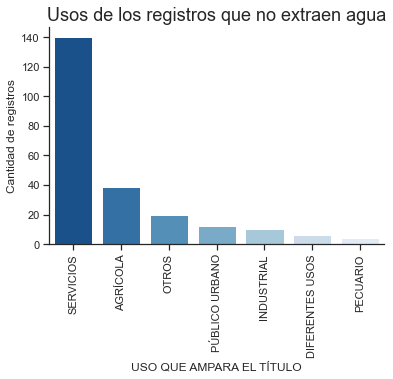

In [8]:
orden = sinExtraccion['USO QUE AMPARA EL TÍTULO'].value_counts().sort_values(ascending=False).index
sns.countplot(x='USO QUE AMPARA EL TÍTULO', data=sinExtraccion, palette='Blues_r', order = orden)
plt.title('Usos de los registros que no extraen agua', fontsize=18)
plt.ylabel("Cantidad de registros")
plt.xticks(rotation=90)
plt.show()

Vemos que la mayoría de los registros en los que **no** se extrae agua tienen como fin los servicios. También vemos que hay dos usos que no se entienden, "OTROS" y "DIFERENTES USOS", los cuales no tenemos forma de saber a qué se refieren.

Podemos ver los titulares que no extraen agua

In [9]:
for titular, registros in zip(sinExtraccion.TITULAR.value_counts().index,sinExtraccion.TITULAR.value_counts()):
    print(f"{titular} tiene {registros} registros donde no se presenta una extracción de agua nacional.\n")

ORGANISMO OPERADOR DE AGUA POTABLE, ALCANTARILLADO Y SANEAMIENTO DE MORELIA tiene 5 registros donde no se presenta una extracción de agua nacional.

NUEVA WAL-MART DE MEXICO, S. DE R.L. DE C.V. tiene 4 registros donde no se presenta una extracción de agua nacional.

JOSE ARMANDO, LILIANA DE LA SALUD Y FRANCISCO JOSE VILLAGOMEZ RIVADENEYRA tiene 2 registros donde no se presenta una extracción de agua nacional.

CRISOBA INDUSTRIAL, S.A. DE C.V. tiene 2 registros donde no se presenta una extracción de agua nacional.

LA VOZ DE MICHOACAN, S.A. DE C.V. tiene 2 registros donde no se presenta una extracción de agua nacional.

PAROM, S.A. DE C.V. tiene 2 registros donde no se presenta una extracción de agua nacional.

TIENDAS COMERCIAL MEXICANA, S.A. DE C.V. tiene 2 registros donde no se presenta una extracción de agua nacional.

ROSA RODRIGUEZ OCHOA tiene 2 registros donde no se presenta una extracción de agua nacional.

UNION NACIONAL DE RESINEROS, A.C. tiene 2 registros donde no se presenta

De esta lista llama la atencia que el OOAPAS esté registrado de dos maneras diferentes, como _ORGANISMO OPERADOR DE AGUA POTABLE, ALCANTARILLADO Y SANEAMIENTO DE MORELIA_ y _ORGANISMO OPERADOR DE AGUA POTABLE ALCANTARILLADO Y SANEAMIENTO DE MORELIA_, lo que nos indica una inconsistencia en los registros, por lo que debemos de arregrarlo.

In [10]:
repdaMor['TITULAR'].replace('ORGANISMO OPERADOR DE AGUA POTABLE, ALCANTARILLADO Y SANEAMIENTO DE MORELIA','ORGANISMO OPERADOR DE AGUA POTABLE ALCANTARILLADO Y SANEAMIENTO DE MORELIA', inplace=True)
sinExtraccion['TITULAR'].replace('ORGANISMO OPERADOR DE AGUA POTABLE, ALCANTARILLADO Y SANEAMIENTO DE MORELIA','ORGANISMO OPERADOR DE AGUA POTABLE ALCANTARILLADO Y SANEAMIENTO DE MORELIA', inplace=True)

/home/jazminlc/.local/lib/python3.8/site-packages/pandas/core/series.py:4575: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Volvemos a revisar a los titulares que no extraen agua

In [11]:
for titular, registros in zip(sinExtraccion.TITULAR.value_counts().index,sinExtraccion.TITULAR.value_counts()):
    print(f"{titular} tiene {registros} registros donde no se presenta una extracción de agua nacional.\n")

ORGANISMO OPERADOR DE AGUA POTABLE ALCANTARILLADO Y SANEAMIENTO DE MORELIA tiene 7 registros donde no se presenta una extracción de agua nacional.

NUEVA WAL-MART DE MEXICO, S. DE R.L. DE C.V. tiene 4 registros donde no se presenta una extracción de agua nacional.

CRISOBA INDUSTRIAL, S.A. DE C.V. tiene 2 registros donde no se presenta una extracción de agua nacional.

ROSA RODRIGUEZ OCHOA tiene 2 registros donde no se presenta una extracción de agua nacional.

INSTITUTO TECNOLOGICO Y DE ESTUDIOS SUPERIORES DE MONTERREY tiene 2 registros donde no se presenta una extracción de agua nacional.

MARTHA IMELDA GONZALEZ HUERTA tiene 2 registros donde no se presenta una extracción de agua nacional.

LA VOZ DE MICHOACAN, S.A. DE C.V. tiene 2 registros donde no se presenta una extracción de agua nacional.

PAROM, S.A. DE C.V. tiene 2 registros donde no se presenta una extracción de agua nacional.

UNION NACIONAL DE RESINEROS, A.C. tiene 2 registros donde no se presenta una extracción de agua na

Otra información que puede ser relevante a la hora de entender porqué hay registros que no extraen agua, es la fecha, ya que es posible que sean registros que se hicieron en cuerpos de agua que ahora ya no existen.

In [12]:
sinExtraccion['FECHA DE REGISTRO'].describe(datetime_is_numeric=True)

count                              231
mean     2005-09-20 07:16:21.818181760
min                1994-07-07 00:00:00
25%                1998-04-08 00:00:00
50%                2004-08-03 00:00:00
75%                2012-09-14 00:00:00
max                2021-07-09 00:00:00
Name: FECHA DE REGISTRO, dtype: object

Vemos que las fechas son realmente variadas por lo que no podemos suponer nada.

Finalmente, debemos destacar el hecho de que el 43.67% de los registros no extraen aguas nacionales.

Ahora podemos enfocarnos en los registros donde sí se extrae agua nacional

In [13]:
conExtraccion = repdaMor[~repdaMor.TÍTULO.isin(sinExtraccion.TÍTULO)]

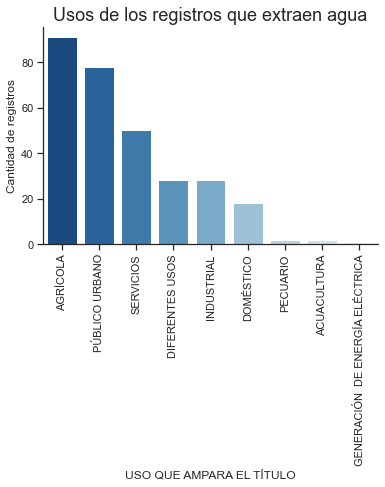

In [14]:
orden = conExtraccion['USO QUE AMPARA EL TÍTULO'].value_counts().sort_values(ascending=False).index
sns.countplot(x='USO QUE AMPARA EL TÍTULO', data=conExtraccion, palette='Blues_r', order = orden)
plt.title('Usos de los registros que extraen agua', fontsize=18)
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=90)
plt.show()

Vemos que la mayoría son de uso agrícola, lo cual coincide con el hecho de que el 76% del agua en México se utilicen con fines agrícolas [con18]. Pero, gracias a la información que tenemos podemos la cantidad de agua que se extra en total para cada uso.

In [15]:
sumExtUso = pd.pivot_table(data=conExtraccion, index = 'USO QUE AMPARA EL TÍTULO', values = 'VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3', aggfunc=np.sum).sort_values(by= 'VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3', ascending=False)

In [16]:
sumExtUso

,VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3
USO QUE AMPARA EL TÍTULO,
PÚBLICO URBANO,92063753.140
INDUSTRIAL,26098004.000
GENERACIÓN DE ENERGÍA ELÉCTRICA,17125000.000
AGRÍCOLA,13096837.280
SERVICIOS,2710206.770
DIFERENTES USOS,1995300.620
DOMÉSTICO,544262.650
ACUACULTURA,217598.400
PECUARIO,13371.260


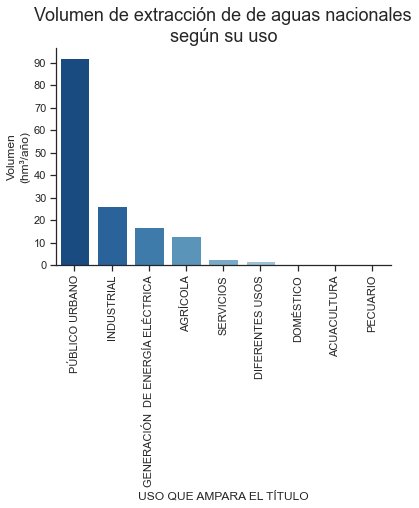

In [17]:
sns.barplot(x=sumExtUso.index,y='VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3', data=sumExtUso, palette='Blues_r')
plt.title('Volumen de extracción de de aguas nacionales\nsegún su uso', fontsize=18)
plt.ylabel('Volumen\n(hm³/año)')
plt.xticks(rotation=90)
plt.yticks(ticks=[int(i) for i in range(0,int(100e6),int(10e6))],labels=[int(i/1e6) for i in range(0,int(100e6),int(10e6))])
plt.show()

Vemos que a pesar de ser el uso más común, el uso agrícola es el cuarto que más extrae agua, siendo el primero el público urbano, seguido del industrial. Otra cosa que llama mucho la atención es el uso de generación de energía eléctrica, pues es el menos común, pero es el tercero que más extrae agua.

## Usos

Ya que pusimos parte de nuestra atención en los usos, valdría la pena revisarlos a fondo.

Lo primero que podemos hacer es revisar la cantidad de registros que hay para cada título.

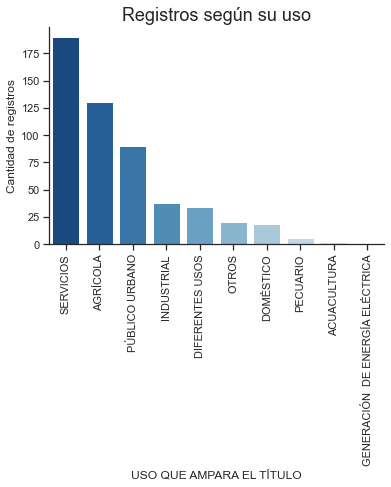

In [18]:
#Distribución
orden = repdaMor['USO QUE AMPARA EL TÍTULO'].value_counts().sort_values(ascending=False).index
sns.countplot(x='USO QUE AMPARA EL TÍTULO', data=repdaMor, palette='Blues_r', order = orden)
plt.title('Registros según su uso', fontsize=18)
plt.ylabel("Cantidad de registros")
plt.xticks(rotation=90)
plt.show()

Vemos que la mayoría de los registros tienen como fin el uso de servicios.

Lo siguienet que puede llamar la atención, es si hay tiutulares que tengan control sobre cierto uso

In [19]:
usosTitular = pd.pivot_table(data=repdaMor, columns='USO QUE AMPARA EL TÍTULO', values='VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3',index='TITULAR', aggfunc='count')
usosTitular.fillna(0,inplace=True)

In [20]:
usosTitular.head()

USO QUE AMPARA EL TÍTULO,ACUACULTURA,AGRÍCOLA,DIFERENTES USOS,DOMÉSTICO,GENERACIÓN DE ENERGÍA ELÉCTRICA,INDUSTRIAL,OTROS,PECUARIO,PÚBLICO URBANO,SERVICIOS
TITULAR,,,,,,,,,,
"AAK MEXICO, S. A. DE C. V.",0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
ABELINO JAVIER GUTIERREZ VENEGAS,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"ACEITES ESPECIALES TH, S. A. DE C. V.",0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
ADAN RENTERIA LOMELI,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"ADMINISTRACION DEPORTIVA ESPECIALIZADA, S.A. DE C.V.",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


Revisamos los tres titulares con más títulos para cada uno de los usos

In [21]:
for col in usosTitular.columns:
    print(col.center(80))
    print(usosTitular.sort_values(by=col, ascending=False)[col].head(3))

                                  ACUACULTURA                                   
TITULAR
JORGE ARMANDO JIMENEZ DE LA TORRE   1.000
ESVEYDE MARTINEZ BASURTO            1.000
AAK MEXICO, S. A. DE C. V.          0.000
Name: ACUACULTURA, dtype: float64
                                    AGRÍCOLA                                    
TITULAR
JOSE ALFREDO GODINEZ MALFAVON                     2.000
UNIVERSIDAD AUTONOMA CHAPINGO                     2.000
ROMULO AMARO GONZALEZ, HELIODORO AMARO GONZALEZ   2.000
Name: AGRÍCOLA, dtype: float64
                                DIFERENTES USOS                                 
TITULAR
EJIDO COINTZIO                         2.000
VICTOR MANUEL VILLICAÑA MALDONADO      2.000
CARLOS ALEJANDRO VILLICAÑA MALDONADO   2.000
Name: DIFERENTES USOS, dtype: float64
                                   DOMÉSTICO                                    
TITULAR
SALVADOR ABUD ANTONIO            1.000
AMPLIACION DEL EJIDO EL PARIAN   1.000
PLACIDO PEREZ CORTES             1

Vemos que realmente solo para el la generación de energía eléctrica y el uso público urbano, que son dominados por la CFE y el OOAPAS respectivamente. 

Lo siguiente en lo que nos podemos enfocar es en la superficie total de cada uso.

In [22]:
sumSupUso = pd.pivot_table(data=repdaMor, index = 'USO QUE AMPARA EL TÍTULO', values = 'SUPERFICIE EN m2', aggfunc=np.sum).sort_values(by='SUPERFICIE EN m2', ascending=False)

In [23]:
sumSupUso

,SUPERFICIE EN m2
USO QUE AMPARA EL TÍTULO,
SERVICIOS,314293.800
AGRÍCOLA,191730.250
PECUARIO,42935.000
OTROS,9510.000
DIFERENTES USOS,448.720
INDUSTRIAL,20.000
ACUACULTURA,0.000
DOMÉSTICO,0.000
GENERACIÓN DE ENERGÍA ELÉCTRICA,0.000


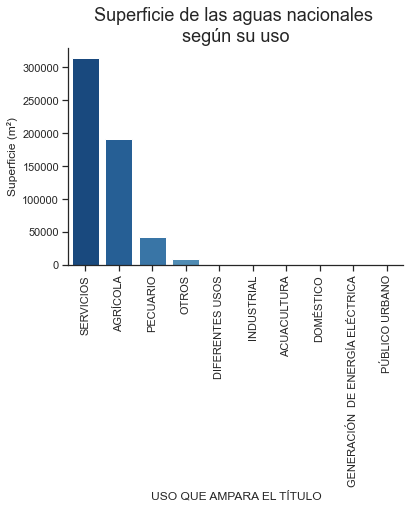

In [24]:
sns.barplot(x=sumSupUso.index,y='SUPERFICIE EN m2', data=sumSupUso, palette='Blues_r')
plt.title('Superficie de las aguas nacionales \nsegún su uso', fontsize=18)
plt.ylabel('Superficie (m²)')
plt.xticks(rotation=90)
plt.show()

Llama la atención que no se cuente con la información de la superficie de los tres usos que más extraen agua, por lo que debemos revisar qué pasa con estre atributo.

In [25]:
repdaMor['SUPERFICIE EN m2'].describe()

count     529.000
mean     1056.593
std      4361.806
min         0.000
25%         0.000
50%         0.000
75%        80.000
max     40520.000
Name: SUPERFICIE EN m2, dtype: float64

Vemos que no se cuenta con esta información para más de la mitad de los registros.

In [26]:
print(f"No se cuenta con la superficie del {sum(repdaMor['SUPERFICIE EN m2']==0)/repdaMor.shape[0]*100:.3f}% de los datos")

No se cuenta con la superficie del 67.108% de los datos


## Anexos
Los anexos hacen referencia a los cuerpos de agua que están registrados para cada título, un título puede tener más de un anexo y de diferente clase. Las clases de anexos son _superficiales,subterráneos, zonas federales_ y _descargas_.

Lo primero que nos puede interesar es ver la cantidad total de anexos que hay por uso.

In [27]:
#Anexos
repdaMor['TOTAL DE ANEXOS'] = repdaMor['APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TÍTULO']+repdaMor['APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TÍTULO']+repdaMor['PUNTOS DE DESCARGA QUE AMPARA EL TÍTULO']+repdaMor['ZONAS FEDERALES QUE AMPARA EL TITULO']

In [28]:
usosAnexos =  pd.pivot_table(data=repdaMor, index='USO QUE AMPARA EL TÍTULO', values='TOTAL DE ANEXOS', aggfunc='sum').sort_values('TOTAL DE ANEXOS', ascending=False)
usosAnexos

,TOTAL DE ANEXOS
USO QUE AMPARA EL TÍTULO,
SERVICIOS,267
PÚBLICO URBANO,152
AGRÍCOLA,145
DIFERENTES USOS,57
INDUSTRIAL,45
OTROS,22
DOMÉSTICO,18
PECUARIO,8
ACUACULTURA,3


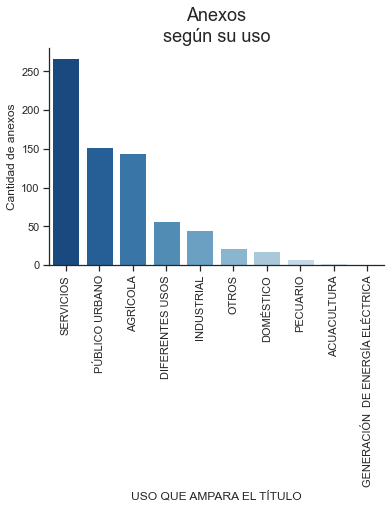

In [29]:
sns.barplot(x=usosAnexos.index,y='TOTAL DE ANEXOS', data=usosAnexos, palette='Blues_r')
plt.title('Anexos\nsegún su uso', fontsize=18)
plt.ylabel('Cantidad de anexos')
plt.xticks(rotation=90)
plt.show()

Vemos que el resultado es similar al del total de registros, lo cual tiene sentido.

Lo siguiente es fijarnos en cada tipo de anexo.

## Superficiales

In [30]:
usosSup = pd.pivot_table(data=repdaMor, index='USO QUE AMPARA EL TÍTULO', values=['APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TÍTULO','VOLUMEN DE EXTRACCIÓN ANUAL DE APROVECHAMIENTOS SUPERFICIALES EN m3'], aggfunc='sum')
usosSup = usosSup.sort_values(by = 'VOLUMEN DE EXTRACCIÓN ANUAL DE APROVECHAMIENTOS SUPERFICIALES EN m3', ascending=False)

In [31]:
usosSup

,APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TÍTULO,VOLUMEN DE EXTRACCIÓN ANUAL DE APROVECHAMIENTOS SUPERFICIALES EN m3
USO QUE AMPARA EL TÍTULO,,
PÚBLICO URBANO,19,61092195.640
GENERACIÓN DE ENERGÍA ELÉCTRICA,1,17125000.000
INDUSTRIAL,1,11037600.000
AGRÍCOLA,34,7956111.520
DIFERENTES USOS,12,752534.920
DOMÉSTICO,11,445583.650
SERVICIOS,5,278821.570
ACUACULTURA,3,217598.400
PECUARIO,2,13371.260


En este caso vemos que el uso agrícola es el que tiene más anexos de tipo superficiales, sin emabrgo, no es el que más extrae agua de este tipo, ese es el público úrbano. En particular, algo que llama la atención es que la generación de energía eléctrica es el segundo uso que más extrae agua de este tipo a pesar de ser un único anexo, es decir, la CFE es el segundo mayor extractor de aguas superficiales en Morelia.

### Subterráneos

In [32]:
usosSub = pd.pivot_table(data=repdaMor, index='USO QUE AMPARA EL TÍTULO', values=['APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TÍTULO','VOLUMEN DE EXTRACCIÓN ANUAL DE APROVECHAMIENTOS SUBTERRÁNEOS EN m3'], aggfunc='sum')
usosSub = usosSub.sort_values(by = 'VOLUMEN DE EXTRACCIÓN ANUAL DE APROVECHAMIENTOS SUBTERRÁNEOS EN m3', ascending=False)

In [33]:
usosSub

,APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TÍTULO,VOLUMEN DE EXTRACCIÓN ANUAL DE APROVECHAMIENTOS SUBTERRÁNEOS EN m3
USO QUE AMPARA EL TÍTULO,,
PÚBLICO URBANO,110,30971557.500
INDUSTRIAL,33,15060404.000
AGRÍCOLA,71,5140725.760
SERVICIOS,52,2431385.200
DIFERENTES USOS,22,1242765.700
DOMÉSTICO,7,98679.000
ACUACULTURA,0,0.000
GENERACIÓN DE ENERGÍA ELÉCTRICA,0,0.000
OTROS,0,0.000


Para este tipo de anexo, vemos que de nuevo el uso público urbano es el  que extrae más agua. Sin embargo, algo que llama la atención es que el uso industrial extrae 2.93 veces más agua que el uso agrícola a pesar de tener menos de la mitad de anexos.

#### Zonas Federales

In [34]:
usosZonFed = pd.pivot_table(data=repdaMor, index='USO QUE AMPARA EL TÍTULO', values=['ZONAS FEDERALES QUE AMPARA EL TITULO','SUPERFICIE EN m2'], aggfunc='sum')
usosZonFed = usosZonFed.sort_values(by = 'SUPERFICIE EN m2', ascending=False)

In [35]:
usosZonFed

,SUPERFICIE EN m2,ZONAS FEDERALES QUE AMPARA EL TITULO
USO QUE AMPARA EL TÍTULO,,
SERVICIOS,314293.800,174
AGRÍCOLA,191730.250,40
PECUARIO,42935.000,5
OTROS,9510.000,21
DIFERENTES USOS,448.720,3
INDUSTRIAL,20.000,1
ACUACULTURA,0.000,0
DOMÉSTICO,0.000,0
GENERACIÓN DE ENERGÍA ELÉCTRICA,0.000,0


Vemos que nos da exactamente los mismos resultados que cuando analizamos la superficie según los usos, por lo que ahora sabemos que el atributo de superficie solo está presente en aquellos registros con una zona federal. Por esto debemos ver aquellos títulos donde se tengan exclusivamente zonas federales.

In [36]:
temp = repdaMor[(repdaMor['ZONAS FEDERALES QUE AMPARA EL TITULO']>0)&(repdaMor['APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TÍTULO']==0)&(repdaMor['APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TÍTULO']==0)&(repdaMor['PUNTOS DE DESCARGA QUE AMPARA EL TÍTULO']==0)].shape[0]
print(f"Hay {temp} registros que solo tienen zonas federales.")
print(f"Eso representa el {temp/repdaMor.shape[0]*100:.3f}% de los datos totales.")
print(f"Y el {temp/231*100:.3f}% de los registros que no extraen agua")

Hay 172 registros que solo tienen zonas federales.
Eso representa el 32.514% de los datos totales.
Y el 74.459% de los registros que no extraen agua


### Descargas

In [37]:
usosDes = pd.pivot_table(data=repdaMor, index='USO QUE AMPARA EL TÍTULO', values=['PUNTOS DE DESCARGA QUE AMPARA EL TÍTULO','VOLUMEN DE DESCARGA DIARIO EN m3'], aggfunc='sum')
usosDes = usosDes.sort_values(by =  'VOLUMEN DE DESCARGA DIARIO EN m3', ascending=False)

In [38]:
usosDes

,PUNTOS DE DESCARGA QUE AMPARA EL TÍTULO,VOLUMEN DE DESCARGA DIARIO EN m3
USO QUE AMPARA EL TÍTULO,,
PÚBLICO URBANO,23,153051.380
INDUSTRIAL,10,29418.900
SERVICIOS,36,1332.740
DIFERENTES USOS,20,102.000
PECUARIO,1,0.450
ACUACULTURA,0,0.000
AGRÍCOLA,0,0.000
DOMÉSTICO,0,0.000
GENERACIÓN DE ENERGÍA ELÉCTRICA,0,0.000


De nuevo es el uso público el que mayor volumen tiene, sin embargo, llama la atención que solo se presente el volumen diario cuando en los otros anexos se nos presenta el volumen anual, y es más interesante porque dentro de la base de anexos que está disponible, sí se cuenta con el volumen anual de descarga. También valdría la pena revisar qué pasa con el volumen de extracción de aguas cuando solo se cuenta con este tipo de anexo.

In [39]:
temp = repdaMor[(repdaMor['ZONAS FEDERALES QUE AMPARA EL TITULO']==0)&(repdaMor['APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TÍTULO']==0)&(repdaMor['APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TÍTULO']==0)&(repdaMor['PUNTOS DE DESCARGA QUE AMPARA EL TÍTULO']>0)].shape[0]
print(f"Hay {temp} registros que solo tienen puntos de descarga.")
print(f"Eso representa el {temp/repdaMor.shape[0]*100:.3f}% de los datos totales.")
print(f"Y el {temp/231*100:.3f}% de los registros que no extraen agua")

Hay 56 registros que solo tienen puntos de descarga.
Eso representa el 10.586% de los datos totales.
Y el 24.242% de los registros que no extraen agua


Con esto ya tenemos cubierto la mayor parte de los registros donde no se extrae agua.

## Titulares

El siguiente punto de interés es revisar quién es dueño del agua, por lo que nos enfocaremos en los titulares que aparecen en el registro.

In [40]:
#Con más de un registro
titgt2 = repdaMor.TITULAR.value_counts()[:36].index

Usos

In [41]:
titularUsos = pd.pivot_table(data=repdaMor[repdaMor.TITULAR.isin(titgt2)], columns='USO QUE AMPARA EL TÍTULO', values='VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3',index='TITULAR', aggfunc='count')
titularUsos.fillna(0,inplace=True)
titularUsos['TOTAL'] = sum([usosTitular[col] for col in usosTitular.columns])
titularUsos.sort_values(by='TOTAL', ascending=False,inplace=True)

In [42]:
titularUsos

USO QUE AMPARA EL TÍTULO,ACUACULTURA,AGRÍCOLA,DIFERENTES USOS,INDUSTRIAL,OTROS,PECUARIO,PÚBLICO URBANO,SERVICIOS,TOTAL
TITULAR,,,,,,,,,
ORGANISMO OPERADOR DE AGUA POTABLE ALCANTARILLADO Y SANEAMIENTO DE MORELIA,0.000,0.000,0.000,0.000,0.000,0.000,45.000,5.000,50.000
"NUEVA WAL-MART DE MEXICO, S. DE R.L. DE C.V.",0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,4.000
"BEBIDAS AZTECA DEL CENTRO, S.A. DE C.V.",0.000,0.000,0.000,2.000,1.000,0.000,0.000,0.000,3.000
"LA VOZ DE MICHOACAN, S.A. DE C.V.",0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,3.000
"RESIDENCIAL TORREON NUEVO, S. A. DE C. V.",0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,3.000
INSTITUTO TECNOLOGICO Y DE ESTUDIOS SUPERIORES DE MONTERREY,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,3.000
"ROMULO AMARO GONZALEZ, HELIODORO AMARO GONZALEZ",0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
"PAROM, S.A. DE C.V.",0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,2.000
"RESINAS SINTETICAS, S.A. DE C.V.",0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,2.000


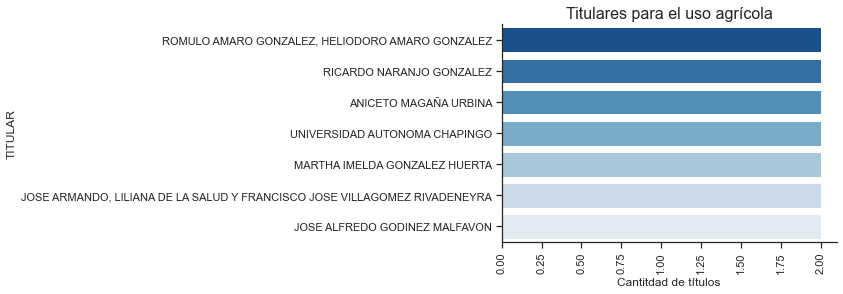

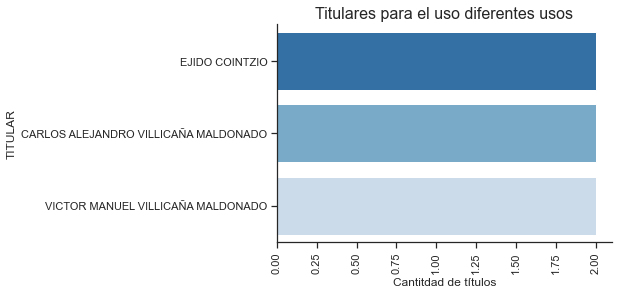

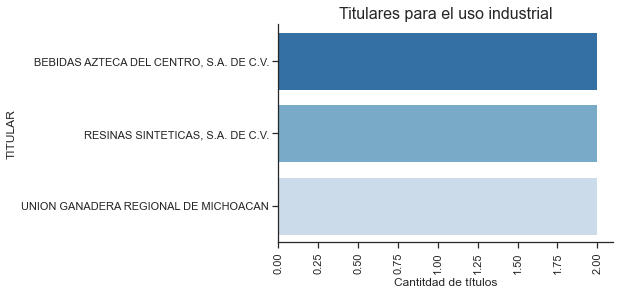

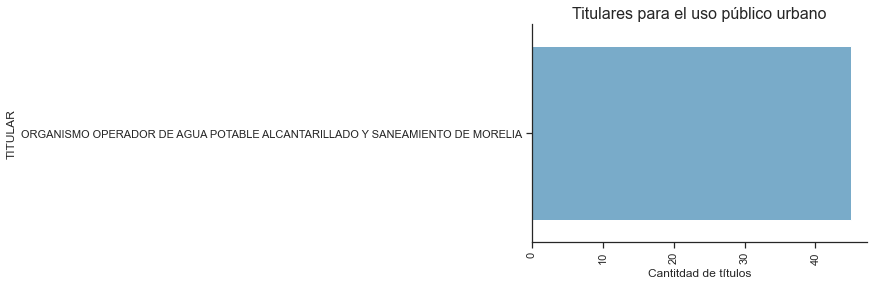

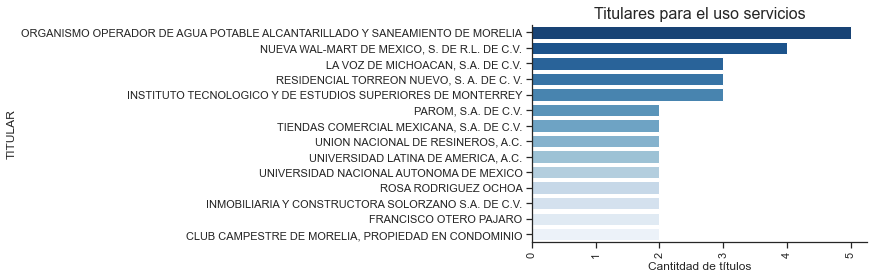

In [43]:
for col in titularUsos.columns[:-1]:
    temp = titularUsos[titularUsos[col]>1].sort_values(by=col, ascending=False)
    if temp.shape[0]==0:
        continue
    sns.barplot(y=temp.index,x=temp[col], palette='Blues_r')
    plt.title("Titulares para el uso "+col.lower(),fontsize=16)
    plt.xlabel("Cantitdad de títulos")
    plt.xticks(rotation=90)
    plt.show()

Vemos que solo para el uso público urbano hay un claro dueño y ese es el OOAPAS.

Lo siguiente es revisar la cantidad de títulos que tiene cada titular.

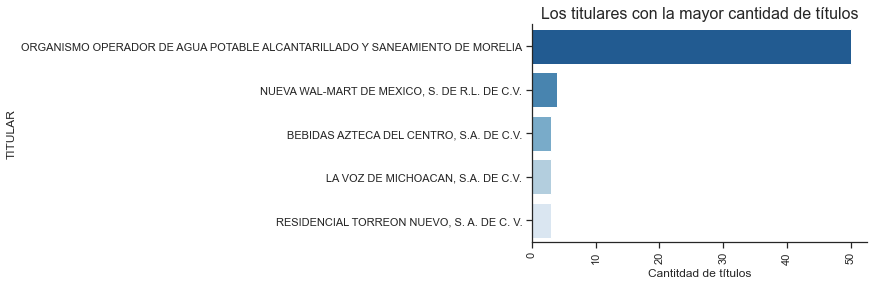

In [44]:
sns.barplot(y=titularUsos.head(5).index,x=titularUsos.head(5)['TOTAL'], palette='Blues_r')
plt.title("Los titulares con la mayor cantidad de títulos",fontsize=16)
plt.xlabel("Cantitdad de títulos")
plt.xticks(rotation=90)
plt.show()

Vemos que el OOAPAS es por mucho el organismo con la mayor cantidad de títulos.

Los siguiente es revisar cuánta agua es extraída por cada uno de los títulares.

In [45]:
titularesExtra = pd.pivot_table(data=repdaMor, index = 'TITULAR', values = 'VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3', aggfunc='sum')
titularesExtra.sort_values(by='VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3', ascending=False, inplace=True)

In [46]:
titularesExtra

,VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3
TITULAR,
ORGANISMO OPERADOR DE AGUA POTABLE ALCANTARILLADO Y SANEAMIENTO DE MORELIA,87102219.980
CRISOBA INDUSTRIAL S.A. DE C.V.,22075200.000
COMISION FEDERAL DE ELECTRICIDAD,17125000.000
"POBLADO ""SAN ANTONIO PARANGARE""",2488320.000
EJIDO SANTIAGO UNDAMEO,1531392.000
...,...
INSTITUTO TECNOLOGICO DE MORELIA,0.000
"INTEGRA MM, S. A. DE C. V.",0.000
ISAIAS ARROYO GALLEGOS,0.000


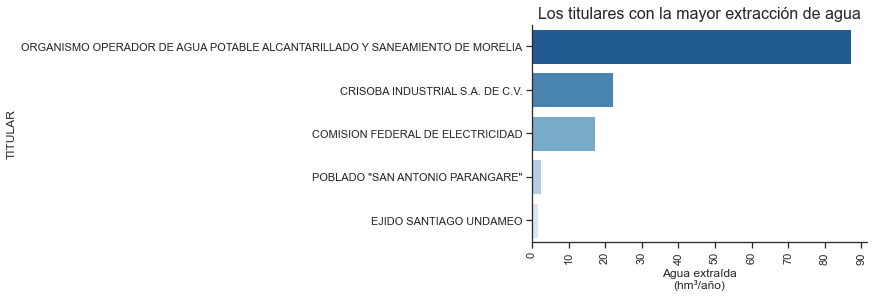

In [47]:
sns.barplot(y=titularesExtra.head(5).index,x=titularesExtra.head(5)['VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3'], palette='Blues_r')
plt.title("Los titulares con la mayor extracción de agua",fontsize=16)
plt.xlabel("Agua extraída\n(hm³/año)")
plt.xticks(ticks=[int(i) for i in range(0,int(100e6),int(10e6))],labels=[int(i/1e6) for i in range(0,int(100e6),int(10e6))],rotation=90)
plt.show()

Una vex más, es el OOAPAS el titular que más destaca, sin embargo, tanto CRISOBA INDUSTRIAL S.A. DE C.V. como la CFE no están presentes en los titulares con más títulos. Por ello valdría la pena revisar el promedio de extracción por los anexos totales que sirven para la extracción.

In [48]:
titularesExtraAvg = pd.pivot_table(data=repdaMor, index = 'TITULAR', values = ['VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3','APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TÍTULO','APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TÍTULO'], aggfunc='sum')
titularesExtraAvg['ANEXOS DE EXTRACCIÓN'] = titularesExtraAvg['APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TÍTULO']+ titularesExtraAvg['APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TÍTULO']
titularesExtraAvg = titularesExtraAvg[titularesExtraAvg['ANEXOS DE EXTRACCIÓN']>0]
titularesExtraAvg['PROMEDIO EN m3'] = titularesExtra['VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3']/ titularesExtraAvg['ANEXOS DE EXTRACCIÓN']
titularesExtraAvg.sort_values(by='PROMEDIO EN m3', ascending=False, inplace=True)

In [49]:
titularesExtraAvg

,APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TÍTULO,APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TÍTULO,VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TÍTULO EN m3,ANEXOS DE EXTRACCIÓN,PROMEDIO EN m3
TITULAR,,,,,
COMISION FEDERAL DE ELECTRICIDAD,0,1,17125000.000,1,17125000.000
CRISOBA INDUSTRIAL S.A. DE C.V.,1,1,22075200.000,2,11037600.000
"POBLADO ""SAN ANTONIO PARANGARE""",0,1,2488320.000,1,2488320.000
ORGANISMO OPERADOR DE AGUA POTABLE ALCANTARILLADO Y SANEAMIENTO DE MORELIA,81,8,87102219.980,89,978676.629
URDERAL HUMBERTO GUZMAN,0,1,943388.000,1,943388.000
...,...,...,...,...,...
FELIPE RENDON MEDINA,0,1,383.250,1,383.250
"EL PINO, S.A. DE C.V.",1,0,338.000,1,338.000
FRANCISCO SUAREZ PARRA,1,0,329.000,1,329.000


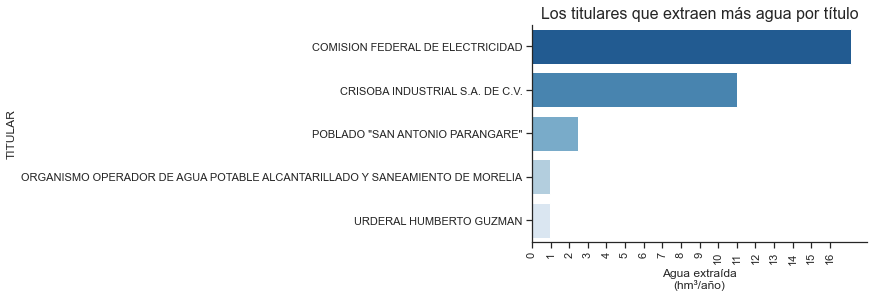

In [50]:
sns.barplot(y=titularesExtraAvg.head(5).index,x=titularesExtraAvg.head(5)['PROMEDIO EN m3'], palette='Blues_r')
plt.title("Los titulares que extraen más agua por título",fontsize=16)
plt.xlabel("Agua extraída\n(hm³/año)")
plt.xticks(ticks=[int(i) for i in range(0,int(17e6),int(1e6))],labels=[int(i/1e6) for i in range(0,int(17e6),int(1e6))],rotation=90)
plt.show()

Vemos que en promedio la CFE y CRISOBA INDUSTRIAL S.A. DE C.V. son quienes extraen la mayor cantidad de aguas nacionales en Morelia.

Lo siguiente es ver la cantidad de anexos que tiene cada titular.

In [51]:
titularesAnexo = pd.pivot_table(data=repdaMor, index = 'TITULAR', values = 'TOTAL DE ANEXOS', aggfunc='sum')
titularesAnexo.sort_values(by='TOTAL DE ANEXOS', ascending=False, inplace=True)

In [52]:
titularesAnexo.head()

,TOTAL DE ANEXOS
TITULAR,
ORGANISMO OPERADOR DE AGUA POTABLE ALCANTARILLADO Y SANEAMIENTO DE MORELIA,109
"AGROPECUARIA TARASCA, S. DE P.R. DE R.L.",13
"CONSTRUCTORA E INMOBILIARIA VALLADOLID, S.A. DE C.V.",9
INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO,8
CARLOS ALEJANDRO VILLICAÑA MALDONADO,7


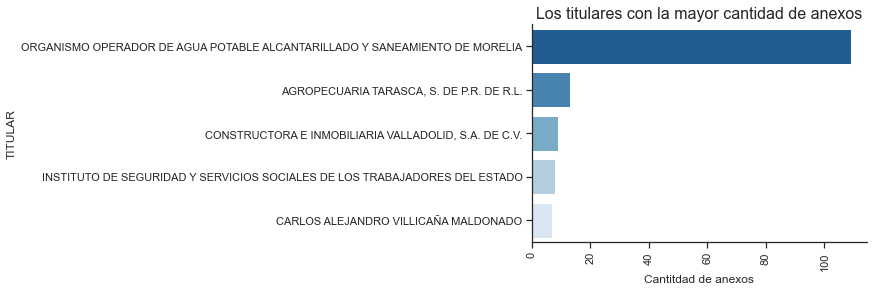

In [53]:
sns.barplot(y=titularesAnexo.head(5).index,x=titularesAnexo.head(5)['TOTAL DE ANEXOS'], palette='Blues_r')
plt.title("Los titulares con la mayor cantidad de anexos",fontsize=16)
plt.xlabel("Cantitdad de anexos")
plt.xticks(rotation=90)
plt.show()

De nuevo aparece el OOAPAS en primer lugar, pero llama la atención la aparición de otros titulares que no figuraban por tener una gran cantidad de registros o extracción de agua.

Lo siguiente que podemos revisar es la superficie, teniendo en cuenta que tendremos como resultado unicamente a aquellos que tienen anexos de Zonas Federales.

In [54]:
titularesSuper = pd.pivot_table(data=repdaMor, index = 'TITULAR', values = 'SUPERFICIE EN m2', aggfunc='sum')
titularesSuper.sort_values(by='SUPERFICIE EN m2', ascending=False, inplace=True)

In [55]:
titularesSuper

,SUPERFICIE EN m2
TITULAR,
MIGUEL ALVARADO VILLA,40520.000
CELIN CORTES GALLEGOS,36312.500
"PAROM, S.A. DE C.V.",36100.000
ORGANISMO OPERADOR DE AGUA POTABLE ALCANTARILLADO Y SANEAMIENTO DE MORELIA,33367.000
"INTEGRA MM, S. A. DE C. V.",33000.000
...,...
FRANCISCO AGUILAR CHAVEZ,0.000
"FONDO DE GARANTIA Y FOMENTO PARA LA AGRICULTURA, GANADERIA Y AVICULTURA",0.000
FONDO DE GARANTIA Y FOMENTO PARA LA AGRICULTURA GANADERIA Y AVICULTURA,0.000


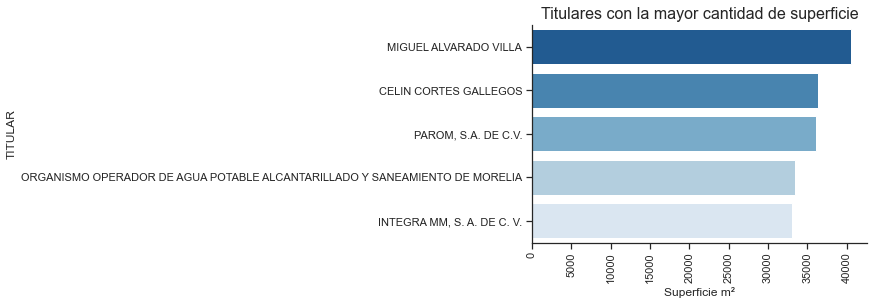

In [56]:
sns.barplot(y=titularesSuper.head(5).index,x=titularesSuper.head(5)['SUPERFICIE EN m2'], palette='Blues_r')
plt.title("Titulares con la mayor cantidad de superficie",fontsize=16)
plt.xlabel("Superficie m²")
plt.xticks(rotation=90)
plt.show()

Vemos que la mayor cantidad de superficie la tiene un particular.

## Fechas

### Títulos

Una de las cosas que llama la atención es la variadad de formatos que existen para el título, de acuerdo al  [diccionario de datos](https://files.conagua.gob.mx/conagua/Diccionarios/Diccionario_Datos_concesiones.pdf), la longitud del título debería ser de 20 caracteres, son embargo, hay algunos que solo tienen digitos. 

Para revisar los formatos, nos vamos a enfocar en las longitudes

In [57]:
pd.Series(repdaMor.TÍTULO.apply(lambda x: len(x))).value_counts()

20    368
19     87
6      35
9      26
11     13
Name: TÍTULO, dtype: int64

Veamos ejemplos para cada longitud

In [58]:
for l in [20,19,6,9,11]:
    temp = repdaMor[repdaMor.TÍTULO.apply(lambda x: len(x))==l]['TÍTULO'].head(1)
    print(f"Título con {l} caracteres:")
    print(list(temp)[0])


Título con 20 caracteres:
08MCH102078/12AOGE00
Título con 19 caracteres:
4MCH100151/12FMGR94
Título con 6 caracteres:
814967
Título con 9 caracteres:
MCH100116
Título con 11 caracteres:
08MCH104357


Vemos que parece que la diferencia entre el registro de 20 caracteres y el de 19, es que el de 19 no considera el cero inicial, por lo que podemos revisar todos para comprobar que esto es lo que pasa.

In [59]:
np.array(repdaMor[repdaMor.TÍTULO.apply(lambda x: len(x))==19]['TÍTULO'])

array(['4MCH100151/12FMGR94', '4MCH100152/12FMGR94',
       '4MCH100208/12JBSG94', '4MCH100212/12FOSG94',
       '4MCH100548/12FDGE94', '4MCH100608/12LCGE94',
       '4MCH100896/12LCGE94', '4MCH100995/12COGE94',
       '4MCH100996/12IOGE94', '4MCH101002/12COGE94',
       '4MCH101009/12HGGE94', '4MCH101064/12FMGE94',
       '4MCH101078/12HMGE94', '4MCH101198/12LAGE94',
       '4MCH101225/12LCGE94', '4MCH101464/12LCGE94',
       '4MCH101576/12LDGE94', '4MCH101637/12HMGE94',
       '4MCH101835/12FMGE94', '4MCH101854/12LCGE94',
       '4MCH101869/12AOGE94', '4MCH101870/12AAGE94',
       '4MCH101884/12LCGE94', '4MCH101958/12LCGE94',
       '4MCH102082/12LAGE96', '4MCH102132/12LOGE94',
       '4MCH102135/12HMGE94', '4MCH102140/12COGE94',
       '4MCH102173/12HOGE95', '4MCH102207/12AMGE95',
       '4MCH102273/12HMGE95', '4MCH102283/12FMGE95',
       '4MCH102284/12FMGE95', '4MCH102466/12AOGE95',
       '4MCH102497/12IMGE95', '4MCH102516/12EMGE95',
       '4MCH102518/12IMGE95', '4MCH102553/12AO

Con esto comprobamos la sospecha existente. Por lo que entre estos dos formatos, lo que se debe de revisar son las fechas, para ver si fue un cambio que se hizo a partir de algún año.

In [60]:
repdaMor[repdaMor.TÍTULO.apply(lambda x: len(x))==20]['FECHA DE REGISTRO'].describe(datetime_is_numeric=True)

count                              368
mean     2008-01-04 07:57:23.478260992
min                1994-10-17 00:00:00
25%                2000-11-21 06:00:00
50%                2008-04-18 00:00:00
75%                2015-10-01 00:00:00
max                2019-01-21 00:00:00
Name: FECHA DE REGISTRO, dtype: object

In [61]:
repdaMor[repdaMor.TÍTULO.apply(lambda x: len(x))==19]['FECHA DE REGISTRO'].describe(datetime_is_numeric=True)

count                               87
mean     1995-12-02 15:10:20.689655168
min                1994-05-13 00:00:00
25%                1995-05-12 00:00:00
50%                1996-01-04 00:00:00
75%                1996-03-27 00:00:00
max                1998-10-03 00:00:00
Name: FECHA DE REGISTRO, dtype: object

Podemos darnos cuenta que existe un traslape de fehcas entre ambos formatos, lo que nos indica que se trata de una inconsistencia en los registros.

Otra similutud entre los formatos es cuando tienen 9 y 11 caracteres, ya que la diferencia parece ser los dos dígitos antes del _MCH_, a su vez parece ser la primera parte de los que tienen 20 caracteres. Así que vamos a revisar lo que pasa con las fechas de los registros.

In [62]:
repdaMor[repdaMor.TÍTULO.apply(lambda x: len(x))==9]['FECHA DE REGISTRO'].describe(datetime_is_numeric=True)

count                               26
mean     2005-05-24 15:41:32.307692288
min                1994-08-09 00:00:00
25%                1999-12-06 00:00:00
50%                2001-04-15 12:00:00
75%                2012-09-16 06:00:00
max                2018-09-18 00:00:00
Name: FECHA DE REGISTRO, dtype: object

In [63]:
repdaMor[repdaMor.TÍTULO.apply(lambda x: len(x))==11]['FECHA DE REGISTRO'].describe(datetime_is_numeric=True)

count                     13
mean     2006-06-09 00:00:00
min      1994-10-18 00:00:00
25%      1996-10-04 00:00:00
50%      2008-01-17 00:00:00
75%      2014-11-25 00:00:00
max      2019-01-14 00:00:00
Name: FECHA DE REGISTRO, dtype: object

Vemos que de nuevo se traslpa con el formato correcto de 20 caracteres, por lo que podemos decir que se trata de una inconsistencia de formato.

Sin embargo, hay un formato que es totalmente diferente al resto y es el de 6 caracteres, ya que no aparece la palabra _MCH_, solo se trata de dígitos. Así que revisemos las fechas en las que este formato está presente.

In [64]:
repdaMor[repdaMor.TÍTULO.apply(lambda x: len(x))==6]['FECHA DE REGISTRO'].describe(datetime_is_numeric=True)

count                               35
mean     2021-01-22 18:30:51.428571392
min                2020-01-31 00:00:00
25%                2020-08-29 12:00:00
50%                2021-01-15 00:00:00
75%                2021-07-31 12:00:00
max                2021-12-16 00:00:00
Name: FECHA DE REGISTRO, dtype: object

Vemos que para este formato no hay un traslape con el de 20 caracteres, y es el que se ha estado usando recientemente, por lo que puede que se trate de un cambio de formato.

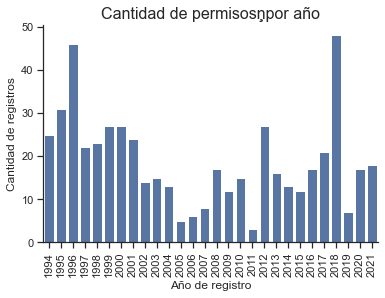

In [65]:
sns.countplot(x = pd.DatetimeIndex(repdaMor['FECHA DE REGISTRO']).year, color='b')
plt.title("Cantidad de permisosņpor año",size=16)
plt.ylabel("Cantidad de registros")
plt.xlabel("Año de registro")
plt.xticks(rotation=90)
plt.show()

Vemos que en 2018 hubo la mayor cantidad de registros y en 2011 la menor. También podemos revisar los meses.

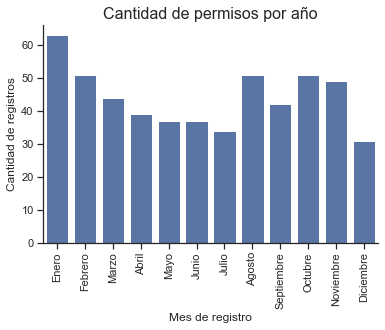

In [66]:
orden = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio',
        'Agosto','Septiembre','Octubre','Noviembre','Diciembre']
sns.countplot(x = pd.DatetimeIndex(repdaMor['FECHA DE REGISTRO']).month_name(), color='b',order=orden)
plt.title("Cantidad de permisos por año",size=16)
plt.ylabel("Cantidad de registros")
plt.xlabel("Mes de registro")
plt.xticks(ticks=list(range(12)),labels=meses,rotation=90)
plt.show()

Naturalmente, es al inicio del año cuando se hacen más registros.

## Autoridades que emiten el acto

In [68]:
repdaMor['AUTORIDAD QUE EMITE EL ACTO'].value_counts()

DIRECCIÓN LOCAL MICHOACÁN                                            520
DIRECCIÓN GENERAL DEL ORGANISMO DE CUENCA LERMA SANTIAGO PACÍFICO      6
SUBDIRECCIÓN GENERAL DE ADMINISTRACIÓN DEL AGUA                        2
SUBDIRECTOR GENERAL DE ADMINISTRACIÓN DEL AGUA                         1
Name: AUTORIDAD QUE EMITE EL ACTO, dtype: int64

Vemos que principalmente es la dirección local de Michoacán quien se encarga de emitir las actas. Sin embargo, llama la atención que una de las autoridades sea la Subdirección General de Administración del agua y otra el subdirector general de administración del agua.

## Pensamientos finales
De manera general, este análisis se complicó más de lo que debería debido a la falta de documentación, en especial por la confusión  de tener dos bases de datos que están presentadas de diferente manera.</br>

Revisando el documento de estadísticas del 2018, podemos encontrar un glosario que nos ayuda a entender mejor lo que significa cada tipo de aprovechamiento.

* **Agua subterránea**: Agua que satura por completo los poros o intersticios del subsuelo.
* **Aguas residuales**: Las aguas de composición variada provenientes de las descargas de usos público urbano, doméstico, industrial, comercial, de servicios, agrícola, pecuario, de las plantas de tratamiento y en general de cualquier otro uso, así como la mezcla de ellas
* **Aguas superficiales**: Agua que fluye o se almacena en la superficie de la corteza terrestre en forma de ríos, lagos o embalses artificiales como presas, bordos y canales.
* **Zona federal**: Las fajas de diez metros de anchura contiguas al cauce de las corrientes o al vaso de los depósitos de propiedad nacional, medidas horizontalmente a partir del Nivel de Aguas Máximas Ordinarias. La amplitud de la ribera o zona federal será de cinco metros en los cauces con una anchura no mayor de cinco metros.

A la par, en este glosario se puede leer lo siguiente. </br>
_Nota: El glosario es una compilación de diversas fuentes,
con el fin de ilustrar los diversos conceptos empleados en
este documento. No constituyen por tanto definiciones con
fuerza legal._

Otra cosa a destacar es que dentro de este libro de estadísticas no se hace mención de un uso llamado "Diferentes Usos"

## Referencias
* [con18] Agua, Comisión N. (Hrsg.): Estadísticas Del Agua En México. http://sina.conagua.gob.mx/publicaciones/EAM_2018.pdf . Version: 2018